In [1]:
%matplotlib inline
import os, sys
import re
import string
import pathlib
import random
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torchtext
from torchtext import data
from torchtext import vocab

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

pd.set_option('display.max_colwidth', -1)

In [2]:
data_root = pathlib.Path('./input')

In [3]:
train_path = './input/train.csv/train.csv'
test_path = './input/test.csv/test.csv'
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
# train_df = train_df.drop(['qid'], axis=1)
# test_df = test_df.drop(['qid'], axis=1)

In [4]:
train_df.shape

(1306122, 3)

In [5]:
# To see what insincere question looks like
train_df.where(train_df.target == 1).dropna().sample(10)

,qid,question_text,target
378504,4a30ab74b82c54c30662,Why were prophet Muhammad's companions so sex-starved that they wanted to castrate themselves?,1.0
826813,a209200f46d83d3ee618,Why cant I just fucking die?,1.0
610982,77a61d96717e6f2dcc40,Are you trying to argue that women haven't been historically oppressed and denied power? I'd say this is more toxic than accounting a historical fiction.,1.0
991978,c25e2de7494d6c1b00eb,Why do most republicans think so highly of themselves?,1.0
1048082,cd5e8fd07ad70d91a6ef,"What makes some Quora users believe that they are superior to other Quora users? Because I know and understand who David Hilbert is, do my questions about Marmosets make me less intelligent?",1.0
1293384,fd7da84d8b97bb2c155a,Have Americans just become informants and snitches for the US government?,1.0
605028,767aea485906197dcf14,When did the Mongolian Gypsies (Turks of Turkey) decide to stop migrating all over the world and settle in Anatolia? Why did the UK and France give them other people’s land? Was it to stop these Gypsy/Nomads from coming to Europe?,1.0
388468,4c1a558d8ca38b864e18,Why aren't tourists given a gun when they visit the US? I feel it's only fair given the fact that they're defenseless against multiple gun owners?,1.0
720674,8d13dd1e74049d293fa7,What does it say about me that I cannot type Hillary Clinton as Hillary Clinton 99% of the time?,1.0
1020076,c7e479f3fbd3984eb2ff,What is the point of having Puerto Rico a part of the united states? They don't seem to bring anything positive to the US.,1.0


In [6]:
# To see what sincere question looks like
train_df.where(train_df.target == 0).dropna().sample(10)

,qid,question_text,target
19954,03e9961181c9ce700d99,Why does Peter Hitchens say there is 'no politics in the Conservative Party'?,0.0
696089,885356e8ed57b8884da1,What is the scariest thing that’s happened to you?,0.0
925657,b5674f821c6133a4b938,What's your best tip to make a sale?,0.0
1058672,cf71a3f6b8ecc2f4ab33,What are the type of Integrin?,0.0
502394,625e46b5e60864e70780,Is resistivity & specific resistance same thing?,0.0
462446,5a8e1f1443e61aa2b57a,How can I create a data model for airport analysis including it's safety and security features?,0.0
193996,25ee049601d837d13e0b,How do I make messy diagrams look attractive in a presentation?,0.0
387146,4bd885f0b38f684cbe44,How many engines do F1 teams use during testing?,0.0
1194583,ea1e25be1832bd53480d,Would it be right to blame the 2008 crisis on the rating agencies .The Right rating would have given the right direction while taking risk?,0.0
783854,998fadf60b22dcc6a606,What is the extension of the hip?,0.0


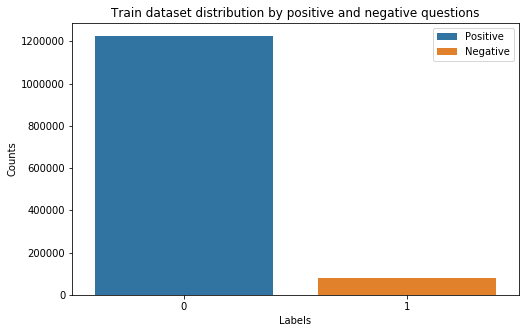

In [7]:
def plot_dist(data=train_df, data_type='Train'):
    fig = plt.figure(figsize=(8,5))
    uniques = data.target.unique()
    counts = data.target.value_counts()
    ax = sns.barplot(x=uniques,y=counts, dodge=False, hue=['0','1'])

    ax.set(xlabel='Labels')
    ax.set(ylabel='Counts')
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles, ["Positive", "Negative"])
    plt.title(data_type + ' dataset distribution by positive and negative questions')
    plt.show()
    
plot_dist(train_df)

In [8]:
train_df['question_text'] = train_df.question_text.progress_apply(lambda x: re.sub('\n', ' ', x))

Progress: 100%|██████████████████████████████████████████████████| 1306122/1306122 [00:04<00:00, 283370.91it/s]


In [14]:
def split_train_test(df, test_size=0.2):
    train, val = train_test_split(df, test_size=test_size,random_state=42)
    return train.reset_index(drop=True), val.reset_index(drop=True)

In [16]:
traindf, valdf = split_train_test(train_df, test_size=0.2)

In [62]:
traindf.shape
valdf.shape

(1044897, 3)

(261225, 3)

In [63]:
traindf.to_csv(data_root/'traindf.csv', index=False)
valdf.to_csv(data_root/'valdf.csv', index=False)

In [64]:
train_df['question_text'][0]

'How did Quebec nationalists see their province as a nation in the 1960s?'

In [65]:
nlp = spacy.load('en',disable=['parser', 'tagger', 'ner'])
def tokenizer(s): return [w.text.lower() for w in nlp(tweet_clean(s))]

In [66]:
def tweet_clean(text):
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric character
    text = re.sub(r'https?:/\/\S+', ' ', text) # remove links
    return text.strip()

In [76]:
TEXT = data.Field(sequential=True, tokenize=tokenizer, include_lengths=True, use_vocab=True)
LABEL = data.Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None)

train_fields = [
    ('qid', None),
    ('question_text', TEXT),
    ('target', LABEL)
]

In [77]:
len(trainds), len(valds)

(1044897, 261225)

In [78]:
%%time
trainds, valds = data.TabularDataset.splits(path='./input/', format='csv', 
                                            train='traindf.csv', validation='valdf.csv', 
                                            fields=train_fields, skip_header=True)

Wall time: 14min 42s


In [80]:
ex = trainds.examples[0]
trainds.fields.items()
ex.target
ex.question_text

dict_items([('qid', None), ('question_text', <torchtext.data.field.Field object at 0x000001EADBC814E0>), ('target', <torchtext.data.field.Field object at 0x000001EADBC81518>)])

'0'

['how',
 'is',
 'strategic',
 'positioning',
 'is',
 'different',
 'from',
 'marketing',
 'positioning']

In [87]:
%%time
vec = vocab.Vectors('word2vec.txt', './input/')

 99%|██████████████████████████████████████████████████████████████▋| 256657/258110 [00:14<00:00, 12829.02it/s]

Wall time: 16.3 s


 99%|██████████████████████████████████████████████████████████████▋| 256657/258110 [00:30<00:00, 12829.02it/s]